In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [7]:
# Load dataset
df = pd.read_csv("/content/trash data.csv")
print(df)


      BIN ID        Date         TIME  WEEK NO FILL LEVEL(IN LITRES)  \
0      BIN 1   10/1/2021  12:00:00 AM        1                     5   
1      BIN 1   10/1/2021  01:00:00 AM        1                    29   
2      BIN 1   10/1/2021  02:00:00 AM        1                    53   
3      BIN 1   10/1/2021  03:00:00 AM        1                    77   
4      BIN 1   10/1/2021  04:00:00 AM        1                   101   
...      ...         ...          ...      ...                   ...   
11036  BIN 5  12/31/2021  07:00:00 PM        5                   480   
11037  BIN 5  12/31/2021  08:00:00 PM        5                   504   
11038  BIN 5  12/31/2021  09:00:00 PM        5                   528   
11039  BIN 5  12/31/2021  10:00:00 PM        5                   552   
11040  BIN 5  12/31/2021  11:00:00 PM        5                   576   

       TOTAL(LITRES) FILL PERCENTAGE   LOCATION     LATITUDE   LONGITUDE  \
0                660              1%  MANAPAKKAM  13.0213° 

In [ ]:
# --- Data Cleaning ---

df['FILL PERCENTAGE'] = (
    df['FILL PERCENTAGE']
    .str.replace('%', '', regex=False)
)
df['FILL PERCENTAGE'] = pd.to_numeric(df['FILL PERCENTAGE'], errors='coerce')


In [8]:
#Clean and convert relevant columns
df['BATTERY LEVEL '] = df['BATTERY LEVEL '].astype(str).str.replace('%', '', regex=False)
df['BATTERY LEVEL '] = pd.to_numeric(df['BATTERY LEVEL '], errors='coerce')

df['TEMPERATURE( IN ⁰C)'] = (
    df['TEMPERATURE( IN ⁰C)'].astype(str)
    .str.replace('ᵒ', '', regex=False)
    .str.replace('°', '', regex=False)
)
df['TEMPERATURE( IN ⁰C)'] = pd.to_numeric(df['TEMPERATURE( IN ⁰C)'], errors='coerce')

df['FILL LEVEL(IN LITRES)'] = pd.to_numeric(df['FILL LEVEL(IN LITRES)'], errors='coerce')
df['LATITUDE'] = df['LATITUDE'].astype(str).str.replace('° N', '', regex=False)
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'], errors='coerce')
df['LONGITUDE'] = df['LONGITUDE'].astype(str).str.replace('° E', '', regex=False)
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'], errors='coerce')

In [9]:
# Convert datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['TIME'], errors='coerce')
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

<ipython-input-9-d969a06aab12>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['TIME'], errors='coerce')


In [10]:
# Encode categorical and target
df['LOCATION '] = pd.factorize(df['LOCATION '])[0]
df['FILL LEVEL INDICATOR(Above 550)'] = df['FILL LEVEL INDICATOR(Above 550)'].map({'TRUE': 1, 'FALSE': 0})

In [11]:
# --- Select Features ---
features = [
    'WEEK NO', 'FILL LEVEL(IN LITRES)', 'TOTAL(LITRES)', 'FILL PERCENTAGE',
    'LOCATION ', 'LATITUDE', 'LONGITUDE', 'TEMPERATURE( IN ⁰C)',
    'BATTERY LEVEL ', 'Hour', 'DayOfWeek', 'Month'
]

In [12]:
# Clean any remaining '%', ensure numeric
for col in features:
    df[col] = df[col].astype(str).str.replace('%', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [13]:
# Drop rows with missing values
df.dropna(subset=features + ['FILL LEVEL INDICATOR(Above 550)'], inplace=True)


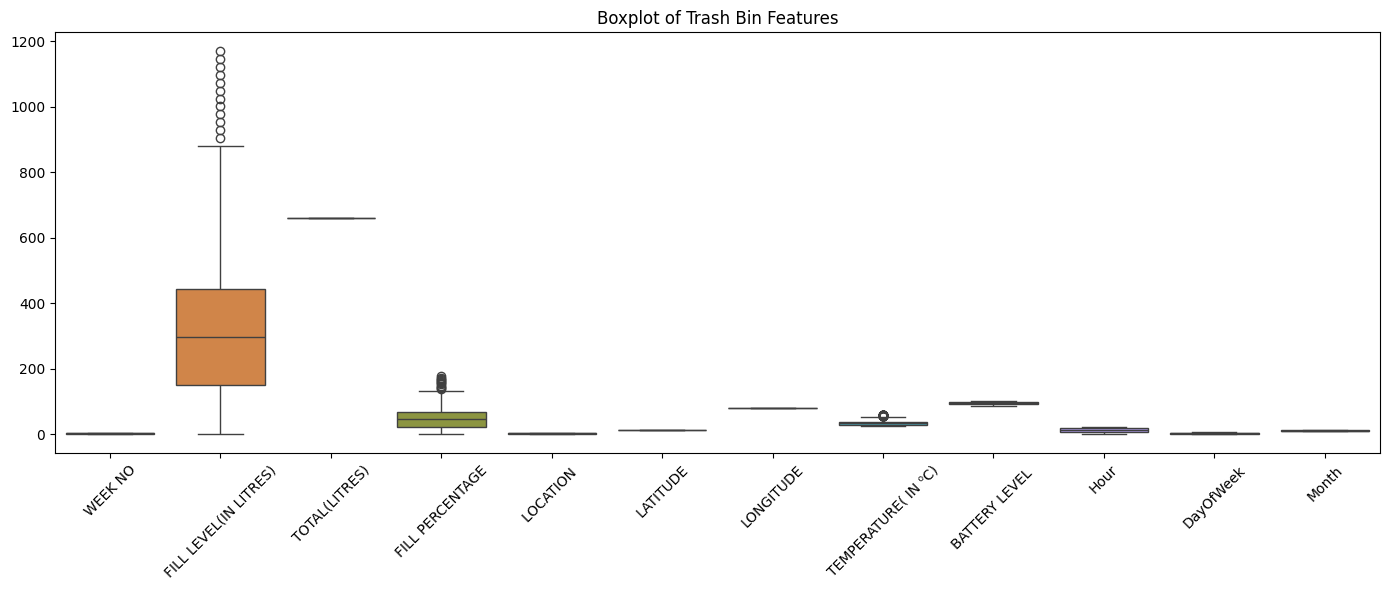

In [14]:
# --- Data Visualization: Boxplot ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[features])
plt.title("Boxplot of Trash Bin Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

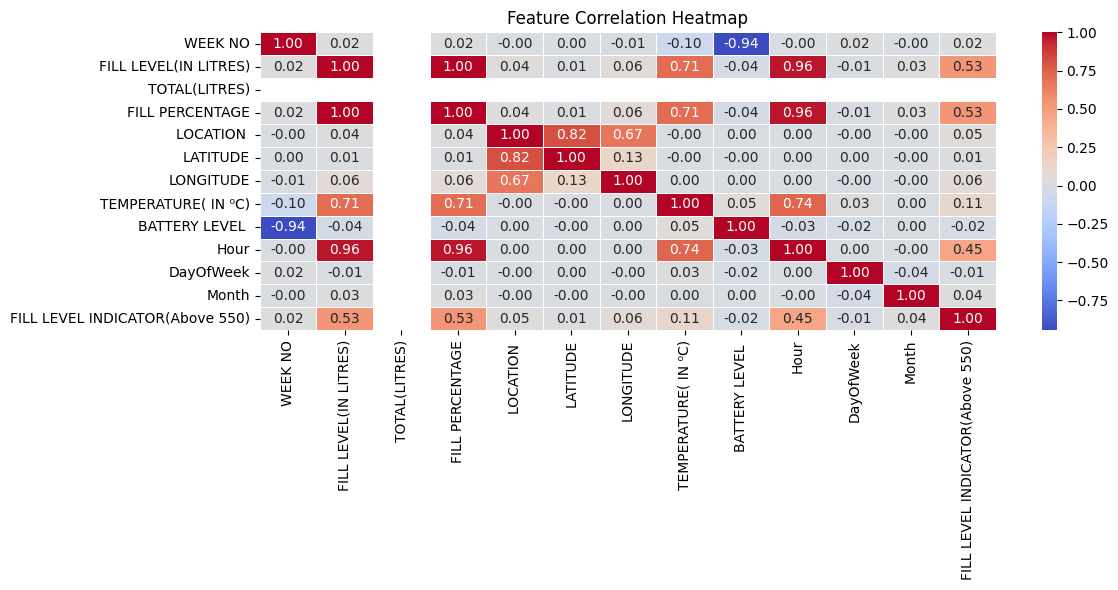

In [15]:
# --- Data Visualization: Correlation Heatmap ---
plt.figure(figsize=(12, 6))
corr_matrix = df[features + ['FILL LEVEL INDICATOR(Above 550)']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [17]:
# --- Prepare Data ---
x = df[features]
y = df['FILL LEVEL INDICATOR(Above 550)']

scaler = StandardScaler()
x = scaler.fit_transform(x)
print("Features shape:", x.shape)
print("Target shape:", y.shape)

Features shape: (8811, 12)
Target shape: (8811,)


In [18]:

# --- Split Data ---
def split_data(x, y, test_size=0.2, random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(x, y)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


x_train shape: (7048, 12)
x_test shape: (1763, 12)
y_train shape: (7048,)
y_test shape: (1763,)


In [19]:
# --- Train Model ---
def train_model(x_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    return model

model = train_model(x_train, y_train)

=== Trash Bin Fullness Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1605
         1.0       1.00      1.00      1.00       158

    accuracy                           1.00      1763
   macro avg       1.00      1.00      1.00      1763
weighted avg       1.00      1.00      1.00      1763

Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
F1-Score: 1.0000
Specificity: 1.0000


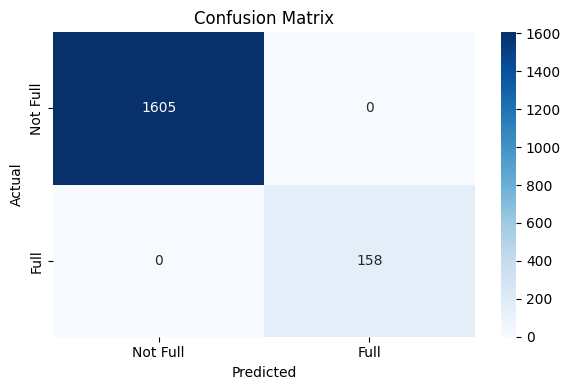

In [20]:
# --- Evaluate Model ---
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    print("=== Trash Bin Fullness Classification Report ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Full", "Full"], yticklabels=["Not Full", "Full"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(model, x_test, y_test)